## **🧮 Import Necessary Libraries**

In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

## **⚓ Create Helper Functions**

In [2]:
# Google Colab
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
# Jupyter Notebook/VS Code
# %pip install wget
# import wget
# wget.download('https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py')

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-05-30 08:51:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-30 08:51:56 (82.2 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## **⏳ Load and Transform Data** <br/>
Before we begin with creating and training our model, we will first set the size of the batches for our training, as well as the image height and width to set for our model

In [3]:
BATCH_SIZE = 100
IMAGE_SIZE = (250, 250)

In [4]:
# Mount data from Google Drive
from google.colab import drive
drive.mount('/content/gdrive')
!unzip /content/gdrive/MyDrive/dataset_reduced.zip > /dev/null

Mounted at /content/gdrive


In [5]:
# Walk through each directory
dataset = "/content/asl_alphabet_train"
# dataset = "./Car Accident/"
walk_through_dir(dataset)

There are 29 directories and 0 images in '/content/asl_alphabet_train'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/Y'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/H'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/W'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/V'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/del'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/K'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/X'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/E'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/D'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/G'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/M'.
There are 0 directories and 500 images in '/content/asl_alphabet_train/B'.
There are 0 directories an

## **📅 Place Data into a Dataframe** <br/>
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [6]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.JPEG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [7]:
image_df

,Filepath,Label
0,/content/asl_alphabet_train/Y/Y2083.jpg,Y
1,/content/asl_alphabet_train/Y/Y2674.jpg,Y
2,/content/asl_alphabet_train/Y/Y1614.jpg,Y
3,/content/asl_alphabet_train/Y/Y2756.jpg,Y
4,/content/asl_alphabet_train/Y/Y2118.jpg,Y
...,...,...
14495,/content/asl_alphabet_train/S/S2675.jpg,S
14496,/content/asl_alphabet_train/S/S2349.jpg,S
14497,/content/asl_alphabet_train/S/S1623.jpg,S
14498,/content/asl_alphabet_train/S/S2811.jpg,S


## **🔭 Visualizing images from the dataset**

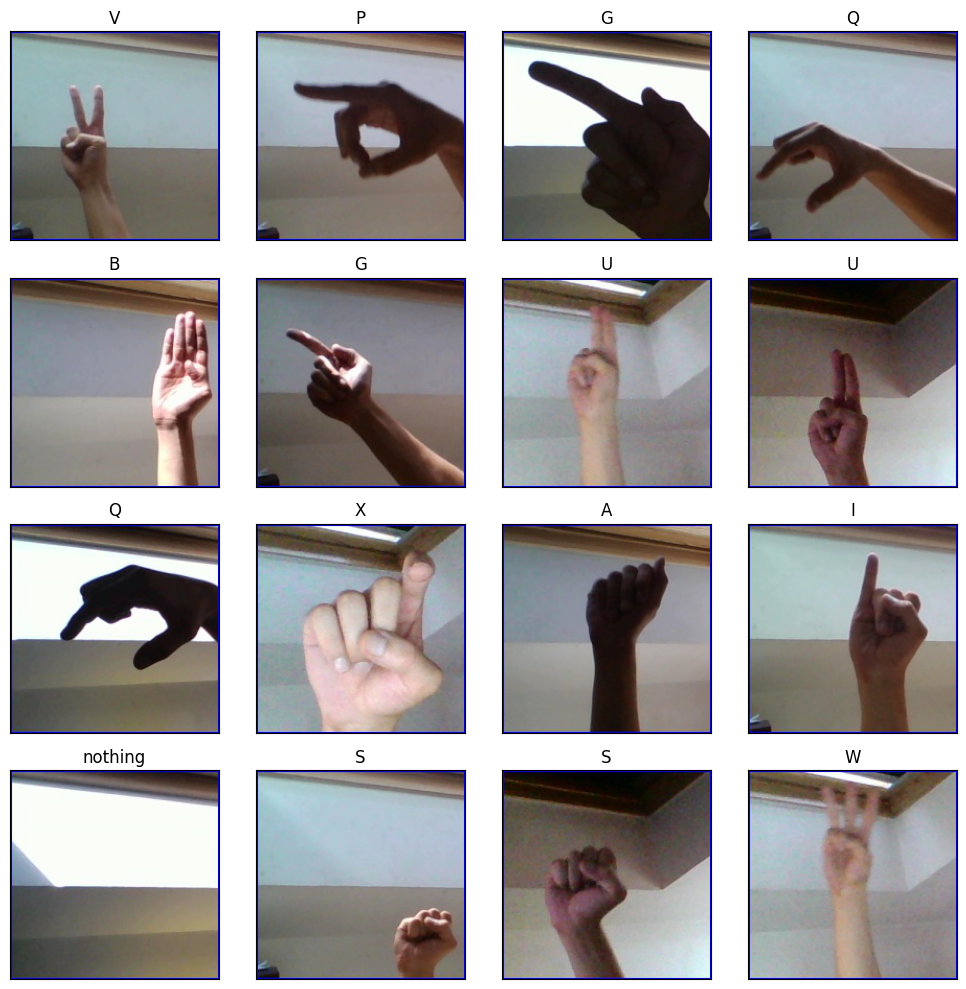

In [8]:
# Display 9 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

## **✍ Data Preprocessing** <br/>
The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).

In [9]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [10]:
from tensorflow.keras.applications.efficientnet import preprocess_input

train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [11]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=101,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=101,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 9280 validated image filenames belonging to 29 classes.
Found 2320 validated image filenames belonging to 29 classes.
Found 2900 validated image filenames belonging to 29 classes.


In [12]:
# Resize Layer
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(250,250),
  layers.experimental.preprocessing.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal_and_vertical"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),                       
], name="data_augmentation")

# **🚓 ASL Classification using EfficientNetV2**




# **🤹Training the model**
The model images will be subjected to a pre-trained CNN model called EfficientNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:

**Batch size** : 100

**Epochs** : 100

**Input Shape** : (250, 250, 3)

**Output layer** : 10

In [13]:
# Load the pretained model
pretrained_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
    input_shape=(250, 250, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

473176280/473176280 [==============================] - 5s 0us/step


In [14]:
# Create checkpoint callback
checkpoint_path = "asl_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [15]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

## **🚄Train the model**

In [16]:
%pip install pillow
import sys
from PIL import Image
sys.modules['Image'] = Image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

# x = Dense(128, activation='relu')(pretrained_model.output)
# x = Dropout(0.45)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.45)(x)

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)

outputs = Dense(29, activation='softmax')(x)

# outputs = Dense(12, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", 
                                    "asl_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/asl_classification/20230530-085336
Epoch 1/50
93/93 [==============================] - 242s 2s/step - loss: 4.9246 - accuracy: 0.0350 - val_loss: 3.6349 - val_accuracy: 0.0466
Epoch 2/50
93/93 [==============================] - 176s 2s/step - loss: 4.0558 - accuracy: 0.0440 - val_loss: 3.3905 - val_accuracy: 0.0651
Epoch 3/50
93/93 [==============================] - 185s 2s/step - loss: 3.6736 - accuracy: 0.0552 - val_loss: 3.2651 - val_accuracy: 0.0961
Epoch 4/50
93/93 [==============================] - 176s 2s/step - loss: 3.5099 - accuracy: 0.0671 - val_loss: 3.1720 - val_accuracy: 0.1237
Epoch 5/50
93/93 [==============================] - 177s 2s/step - loss: 3.3882 - accuracy: 0.0756 - val_loss: 3.0873 - val_accuracy: 0.1509
Epoch 6/50
93/93 [==============================] - 177s 2s/step - loss: 3.2770 - accuracy: 0.0934 - val_loss: 3.0223 - val_accuracy: 0.1901
Epoch 7/50
93/93 [==============================] - 177s 2s/step - loss:

## **✔️ Model Evaluation**

In [18]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.11245
Test Accuracy: 74.62%


## **📉Visualizing loss curves**

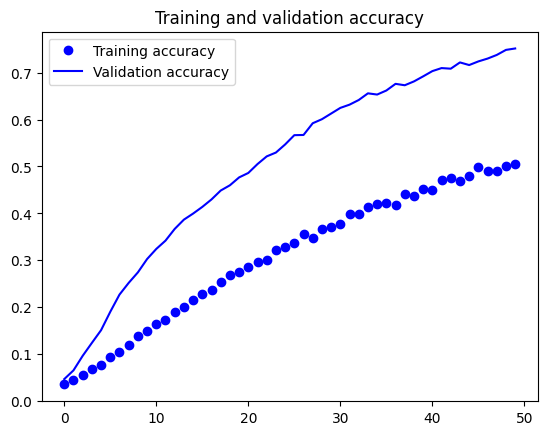

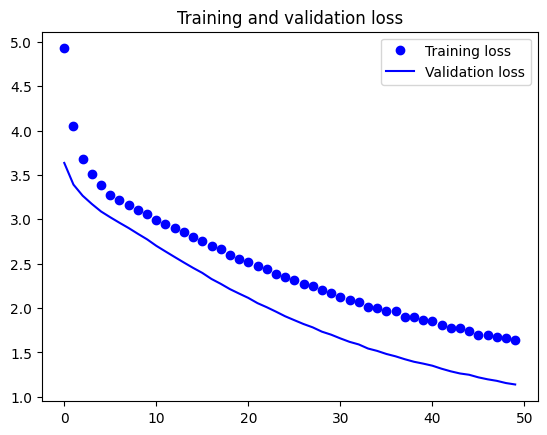

In [19]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

## **🔮Making predictions on the test data**

In [20]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

29/29 [==============================] - 47s 1s/step
The first 5 predictions: ['A', 'P', 'Q', 'T', 'nothing']


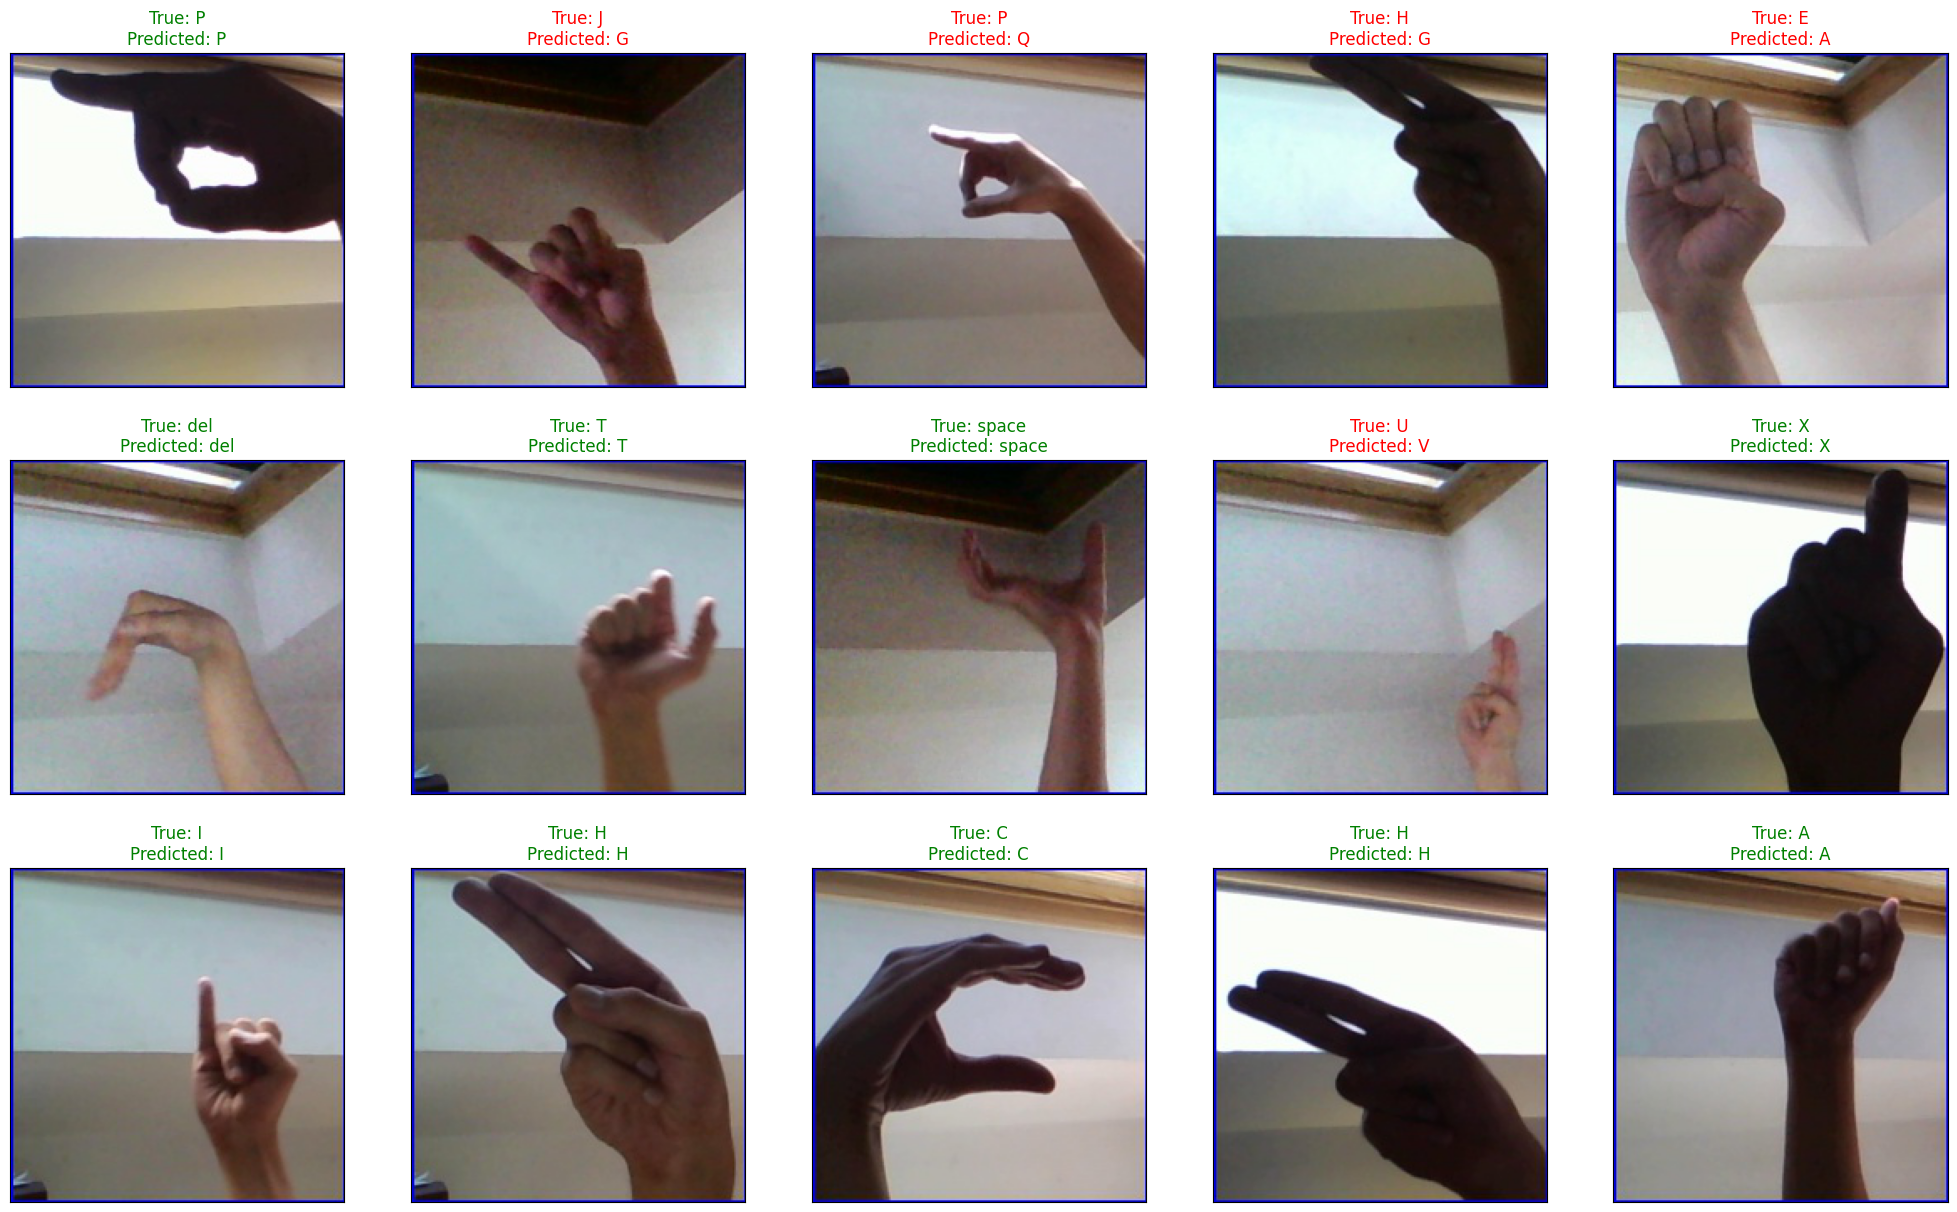

<Figure size 640x480 with 0 Axes>

In [21]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

## **📊Plotting the classification reports**

In [22]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           A       0.57      0.63      0.60        89
           B       0.92      0.75      0.83        95
           C       0.84      0.90      0.87       102
           D       0.87      0.73      0.79       108
           E       0.66      0.70      0.68       104
           F       0.71      0.92      0.80       102
           G       0.76      0.66      0.71        98
           H       0.82      0.74      0.78       104
           I       0.67      0.66      0.67        88
           J       0.60      0.67      0.63       107
           K       0.70      0.68      0.69       103
           L       0.52      0.86      0.65        95
           M       0.69      0.68      0.68        99
           N       0.75      0.74      0.75       116
           O       0.96      0.88      0.92       100
           P       0.93      0.77      0.84        96
           Q       0.84      0.91      0.88       108
           R       0.65    

In [23]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
A,0.571429,0.629213,0.598930,89.000000
B,0.922078,0.747368,0.825581,95.000000
C,0.836364,0.901961,0.867925,102.000000
D,0.868132,0.731481,0.793970,108.000000
E,0.663636,0.701923,0.682243,104.000000
F,0.706767,0.921569,0.800000,102.000000
G,0.755814,0.663265,0.706522,98.000000
H,0.819149,0.740385,0.777778,104.000000
I,0.674419,0.659091,0.666667,88.000000
J,0.600000,0.672897,0.634361,107.000000
